# PRABU - Analisis Model Keuangan Perusahaan

Notebook ini bertujuan untuk melakukan analisis keuangan perusahaan menggunakan beberapa model skor seperti Beneish M-Score, Altman Z-Score, dan rasio keuangan umum untuk penilaian risiko kredit.

## 1. Setup dan Import Library

In [22]:
import json
import sys
import os

# Tambahkan path ke direktori FinancialScoreModels jika notebook ini tidak berada di root yang sama
# module_path = os.path.abspath(os.path.join('..')) # Jika notebook di dalam subfolder
# if module_path not in sys.path:
#     sys.path.append(module_path)

from FinancialScoreModels.utils import load_financial_data, get_company_financial_data # Updated import
from FinancialScoreModels.beneish_m_score import calculate_beneish_m_score
from FinancialScoreModels.altman_z_score import calculate_altman_z_score
from FinancialScoreModels.financial_ratios import calculate_common_financial_ratios

def normalize_financial_data_keys(data_dict):
    """
    Menormalisasi kunci-kunci dalam dictionary data keuangan ke format standar.
    Contoh: "Piutang Usaha" menjadi "Piutang usaha".
    """
    if not isinstance(data_dict, dict):
        return data_dict # Kembalikan apa adanya jika bukan dictionary

    # Pemetaan dari variasi kunci (yang mungkin ada di JSON) ke kunci standar
    # Kunci di sini adalah versi yang MUNGKIN ADA di JSON, nilainya adalah versi STANDAR.
    KEY_MAP = {
        # Variasi untuk Beneish & Altman & Common Ratios
        "Piutang Usaha": "Piutang usaha",
        "Pendapatan Bersih": "Pendapatan bersih",
        "Laba Bruto": "Laba bruto",
        "Jumlah Aset Tidak Lancar": "Jumlah aset tidak lancar",
        "Jumlah Aset": "Jumlah aset",
        "Beban Penyusutan": "Beban penyusutan",
        "Aset Tetap Bruto": "Aset tetap bruto",
        "Beban Penjualan": "Beban penjualan",
        "Beban Administrasi dan Umum": "Beban administrasi dan umum",
        "Jumlah Liabilitas": "Jumlah liabilitas",
        "Laba Tahun Berjalan": "Laba tahun berjalan",
        "Arus Kas Bersih yang Diperoleh dari Aktivitas Operasi": "Arus kas bersih yang diperoleh dari aktivitas operasi",
        "Jumlah Aset Lancar": "Jumlah aset lancar",
        "Aset Tetap": "Aset tetap",
        "Modal Kerja Bersih": "Modal kerja bersih",
        "Laba Ditahan": "Laba ditahan",
        "Laba Sebelum Pajak Penghasilan": "Laba sebelum pajak penghasilan",
        "Beban Bunga": "Beban bunga",
        "Jumlah Ekuitas": "Jumlah ekuitas",
        "Jumlah Liabilitas Jangka Pendek": "Jumlah liabilitas jangka pendek",
        
        # Tambahkan variasi lain jika ditemukan, misalnya semua huruf besar
        "PIUTANG USAHA": "Piutang usaha",
        "PENDAPATAN BERSIH": "Pendapatan bersih",
        "LABA BRUTO": "Laba bruto",
        "JUMLAH ASET TIDAK LANCAR": "Jumlah aset tidak lancar",
        "JUMLAH ASET": "Jumlah aset",
        "BEBAN PENYUSUTAN": "Beban penyusutan",
        "ASET TETAP BRUTO": "Aset tetap bruto",
        "BEBAN PENJUALAN": "Beban penjualan",
        "BEBAN ADMINISTRASI DAN UMUM": "Beban administrasi dan umum",
        "JUMLAH LIABILITAS": "Jumlah liabilitas",
        "LABA TAHUN BERJALAN": "Laba tahun berjalan",
        "ARUS KAS BERSIH YANG DIPEROLEH DARI AKTIVITAS OPERASI": "Arus kas bersih yang diperoleh dari aktivitas operasi",
        "JUMLAH ASET LANCAR": "Jumlah aset lancar",
        "ASET TETAP": "Aset tetap",
        "MODAL KERJA BERSIH": "Modal kerja bersih",
        "LABA DITAHAN": "Laba ditahan",
        "LABA SEBELUM PAJAK PENGHASILAN": "Laba sebelum pajak penghasilan",
        "BEBAN BUNGA": "Beban bunga",
        "JUMLAH EKUITAS": "Jumlah ekuitas",
        "JUMLAH LIABILITAS JANGKA PENDEK": "Jumlah liabilitas jangka pendek",
        # ... tambahkan pemetaan lain yang diperlukan
    }

    normalized_dict = {}
    for key_json, value in data_dict.items():
        # Jika kunci JSON ada di KEY_MAP, gunakan kunci standar. Jika tidak, gunakan kunci JSON apa adanya.
        standard_key = KEY_MAP.get(key_json, key_json) 
        normalized_dict[standard_key] = value
    
    return normalized_dict

## 2. Konfigurasi Path File Data Keuangan dan Nama Perusahaan Target

Atur path ke file JSON yang berisi hasil ekstraksi data keuangan untuk periode `t` (tahun berjalan) dan `t-1` (tahun sebelumnya).
Tentukan juga `TARGET_COMPANY_FILE_NAME` yang akan dianalisis dari dalam file JSON tersebut.

In [23]:
FILE_PATH_T = "Output/Sarana/hasil_ekstraksi_semua_dokumen.json"
FILE_PATH_T_MINUS_1 = "Output/Sarana/hasil_ekstraksi_semua_dokumen_t_minus_1.json"
TARGET_COMPANY_FILE_NAME = "lapkeu_x.pdf"  # Ganti dengan nama file perusahaan yang relevan di JSON Anda

## 3. Memuat Data Keuangan Perusahaan Spesifik

In [24]:
print(f"Memuat semua data keuangan dari: {FILE_PATH_T}")
all_data_t = load_financial_data(FILE_PATH_T) # Ini akan menjadi list

print(f"Memuat semua data keuangan dari: {FILE_PATH_T_MINUS_1}")
all_data_t_minus_1 = load_financial_data(FILE_PATH_T_MINUS_1) # Ini juga akan menjadi list

# Ekstrak data untuk perusahaan target
raw_data_t = None
raw_data_t_minus_1 = None
data_t = None # Akan berisi data yang sudah dinormalisasi kuncinya
data_t_minus_1 = None # Akan berisi data yang sudah dinormalisasi kuncinya

if all_data_t:
    raw_data_t = get_company_financial_data(all_data_t, TARGET_COMPANY_FILE_NAME)
    if raw_data_t:
        data_t = normalize_financial_data_keys(raw_data_t) # Normalisasi kunci
        print(f"\nData Keuangan Periode t untuk {TARGET_COMPANY_FILE_NAME} berhasil dimuat dan dinormalisasi.")
        # print(json.dumps(data_t, indent=2, ensure_ascii=False)) # Uncomment untuk inspeksi data ternormalisasi
    else:
        print(f"\nGagal mendapatkan data keuangan periode t untuk {TARGET_COMPANY_FILE_NAME} dari {FILE_PATH_T}.")
else:
    print(f"\nGagal memuat list data keuangan periode t dari {FILE_PATH_T}.")

if all_data_t_minus_1:
    raw_data_t_minus_1 = get_company_financial_data(all_data_t_minus_1, TARGET_COMPANY_FILE_NAME)
    if raw_data_t_minus_1:
        data_t_minus_1 = normalize_financial_data_keys(raw_data_t_minus_1) # Normalisasi kunci
        print(f"\nData Keuangan Periode t-1 untuk {TARGET_COMPANY_FILE_NAME} berhasil dimuat dan dinormalisasi.")
        # print(json.dumps(data_t_minus_1, indent=2, ensure_ascii=False)) # Uncomment untuk inspeksi data ternormalisasi
    else:
        print(f"\nGagal mendapatkan data keuangan periode t-1 untuk {TARGET_COMPANY_FILE_NAME} dari {FILE_PATH_T_MINUS_1}.")
else:
    print(f"\nGagal memuat list data keuangan periode t-1 dari {FILE_PATH_T_MINUS_1}.")

Memuat semua data keuangan dari: Output/Sarana/hasil_ekstraksi_semua_dokumen.json
Memuat semua data keuangan dari: Output/Sarana/hasil_ekstraksi_semua_dokumen_t_minus_1.json

Data Keuangan Periode t untuk lapkeu_x.pdf berhasil dimuat dan dinormalisasi.

Data Keuangan Periode t-1 untuk lapkeu_x.pdf berhasil dimuat dan dinormalisasi.


## 4. Perhitungan Beneish M-Score

Beneish M-Score digunakan untuk mendeteksi potensi manipulasi laba.

In [25]:
if data_t and data_t_minus_1:
    print("\n--- Menghitung Beneish M-Score ---")
    m_score, m_ratios = calculate_beneish_m_score(data_t, data_t_minus_1)
    
    if m_score is not None:
        print(f"Beneish M-Score: {m_score:.4f}")
        print("Rincian Rasio Beneish:")
        for ratio_name, ratio_value in m_ratios.items():
            if ratio_name != 'error':
                print(f"  {ratio_name}: {ratio_value:.4f}")
        
        # Interpretasi Umum
        if m_score > -1.78: # Batas umum yang sering dikutip
            print("Interpretasi: Kemungkinan besar perusahaan adalah manipulator laba.")
        elif m_score > -2.22:
            print("Interpretasi: Zona abu-abu, perlu investigasi lebih lanjut.")
        else:
            print("Interpretasi: Kemungkinan kecil perusahaan adalah manipulator laba.")
    else:
        print("Gagal menghitung Beneish M-Score.")
        if m_ratios and 'error' in m_ratios:
            print(f"  Alasan: {m_ratios['error']}")
else:
    print("\nData tidak cukup untuk menghitung Beneish M-Score (data t atau t-1 tidak berhasil dimuat).")


--- Menghitung Beneish M-Score ---
Beneish M-Score: -1.4890
Rincian Rasio Beneish:
  DSRI: 0.9654
  GMI: 1.0841
  AQI: 0.9858
  SGI: 1.1395
  DEPI: 1.0000
  SGAI: 0.9654
  LVGI: 1.0134
  TATA: 0.1834
Interpretasi: Kemungkinan besar perusahaan adalah manipulator laba.


## 5. Perhitungan Altman Z-Score

Altman Z-Score digunakan untuk memprediksi probabilitas kebangkrutan perusahaan.

In [26]:
if data_t:
    print("\n--- Menghitung Altman Z-Score ---")
    # Asumsikan perusahaan adalah manufaktur publik untuk contoh ini
    # Ganti model_type jika perlu: "private_manufacturing", "non_manufacturing_or_emerging_markets"
    z_model_type = "public_manufacturing" 
    z_score, z_ratios = calculate_altman_z_score(data_t, model_type=z_model_type)
    
    if z_score is not None:
        print(f"Altman Z-Score (Model: {z_ratios.get('model_type', z_model_type)}): {z_score:.4f}")
        print("Rincian Rasio Altman:")
        for ratio_name, ratio_value in z_ratios.items():
            if ratio_name not in ['error', 'model_type', 'interpretation_zones', 'X4_note']:
                print(f"  {ratio_name}: {ratio_value:.4f}")
        if "X4_note" in z_ratios:
            print(f"  Catatan untuk X4: {z_ratios['X4_note']}")
            
        zones = z_ratios.get("interpretation_zones", {})
        print("Interpretasi Zona:")
        if z_model_type == "public_manufacturing":
            if z_score > 2.99: print("  Perusahaan berada di 'Safe Zone'.")
            elif z_score > 1.81: print("  Perusahaan berada di 'Grey Zone'.")
            else: print("  Perusahaan berada di 'Distress Zone'.")
        elif z_model_type == "private_manufacturing":
            if z_score > 2.90: print("  Perusahaan berada di 'Safe Zone'.")
            elif z_score > 1.23: print("  Perusahaan berada di 'Grey Zone'.")
            else: print("  Perusahaan berada di 'Distress Zone'.")
        elif z_model_type == "non_manufacturing_or_emerging_markets":
            if z_score > 2.60: print("  Perusahaan berada di 'Safe Zone'.")
            elif z_score > 1.10: print("  Perusahaan berada di 'Grey Zone'.")
            else: print("  Perusahaan berada di 'Distress Zone'.")
        print(f"  Detail Zona (dari model): {zones}")
    else:
        print("Gagal menghitung Altman Z-Score.")
        if z_ratios and 'error' in z_ratios:
            print(f"  Alasan: {z_ratios['error']}")
else:
    print("\nData tidak cukup untuk menghitung Altman Z-Score (data t tidak berhasil dimuat).")


--- Menghitung Altman Z-Score ---
Altman Z-Score (Model: Public Manufacturing (1968)): 5.8919
Rincian Rasio Altman:
  X1 (Working Capital / Total Assets): 0.0489
  X2 (Retained Earnings / Total Assets): 0.6435
  X3 (EBIT / Total Assets): 0.2246
  X4 (Market Value of Equity / Total Liabilities): 5.2007
  X5 (Sales / Total Assets): 1.0717
  Catatan untuk X4: Using Book Value of Equity as proxy for Market Value
Interpretasi Zona:
  Perusahaan berada di 'Safe Zone'.
  Detail Zona (dari model): {'Safe Zone': '> 2.99', 'Grey Zone': '1.81 - 2.99', 'Distress Zone': '< 1.81'}


## 6. Perhitungan Rasio Keuangan Umum (untuk Analisis Risiko Kredit)

Rasio-rasio ini memberikan gambaran umum tentang kesehatan keuangan, likuiditas, solvabilitas, dan profitabilitas perusahaan.

In [27]:
if data_t:
    print("\n--- Menghitung Rasio Keuangan Umum ---")
    common_ratios = calculate_common_financial_ratios(data_t)
    
    if "error" in common_ratios:
        print(f"Gagal menghitung rasio keuangan umum: {common_ratios['error']}")
    else:
        print("Rasio Keuangan Umum:")
        for ratio_name, ratio_value in common_ratios.items():
            if not ratio_name.endswith("_note") and not ratio_name.endswith("_error"):
                # Check if ratio_value is a number before formatting
                if isinstance(ratio_value, (int, float)):
                    print(f"  {ratio_name}: {ratio_value:.4f}", end="")
                else:
                    print(f"  {ratio_name}: {ratio_value}", end="")
                
                if f"{ratio_name}_note" in common_ratios:
                    print(f" ({common_ratios[f'{ratio_name}_note']})")
                else:
                    print()
            elif ratio_name.endswith("_error"):
                 print(f"  Error untuk {ratio_name.replace('_error', '')}: {ratio_value}")
        
        # Contoh Sederhana untuk Credit Risk Score Indication
        # Ini adalah contoh yang sangat dasar dan perlu disesuaikan dengan model risiko kredit yang lebih canggih.
        print("\nIndikasi Skor Risiko Kredit:")
        score_points = 0
        reasons = []

        # Debt-to-Equity Ratio
        dte = common_ratios.get("Debt-to-Equity Ratio")
        if isinstance(dte, float):
            if dte < 0.5: score_points += 2; reasons.append(f"D/E Rendah ({dte:.2f})")
            elif dte < 1.0: score_points += 1; reasons.append(f"D/E Sedang ({dte:.2f})")
            else: score_points -=1; reasons.append(f"D/E Tinggi ({dte:.2f})")
        
        # Current Ratio
        cr = common_ratios.get("Current Ratio")
        if isinstance(cr, float):
            if cr > 2.0: score_points += 2; reasons.append(f"Current Ratio Baik ({cr:.2f})")
            elif cr > 1.0: score_points += 1; reasons.append(f"Current Ratio Cukup ({cr:.2f})")
            else: score_points -=1; reasons.append(f"Current Ratio Rendah ({cr:.2f})")

        # Interest Coverage Ratio
        icr = common_ratios.get("Interest Coverage Ratio")
        if isinstance(icr, float):
            if icr == float('inf'): score_points +=2; reasons.append(f"ICR Sangat Baik (Tak Terhingga)") # No interest, good EBIT
            elif icr > 5.0: score_points += 2; reasons.append(f"ICR Baik ({icr:.2f})")
            elif icr > 2.0: score_points += 1; reasons.append(f"ICR Cukup ({icr:.2f})")
            else: score_points -=1; reasons.append(f"ICR Rendah ({icr:.2f})")
            
        # Net Profit Margin
        npm = common_ratios.get("Net Profit Margin")
        if isinstance(npm, float):
            if npm > 0.1: score_points +=2; reasons.append(f"NPM Baik ({npm:.2%})")
            elif npm > 0.05: score_points +=1; reasons.append(f"NPM Cukup ({npm:.2%})")
            elif npm > 0: score_points +=0; reasons.append(f"NPM Positif Rendah ({npm:.2%})")
            else: score_points -=1; reasons.append(f"NPM Negatif ({npm:.2%})")
            
        print(f"Total Poin Skor Kredit (Contoh): {score_points}")
        print(f"Alasan Poin: {', '.join(reasons)}")
        
        if score_points >= 5:
            print("Indikasi Risiko Kredit: Rendah")
        elif score_points >= 2:
            print("Indikasi Risiko Kredit: Sedang")
        else:
            print("Indikasi Risiko Kredit: Tinggi")
else:
    print("\nData tidak cukup untuk menghitung Rasio Keuangan Umum (data t tidak berhasil dimuat).")


--- Menghitung Rasio Keuangan Umum ---
Rasio Keuangan Umum:
  Debt-to-Equity Ratio: 0.1923
  Current Ratio: 1.3453
  Interest Coverage Ratio: 41.2473
  Net Profit Margin: 0.2001
  Gross Profit Margin: 0.0971
  Debt Ratio: 0.1613

Indikasi Skor Risiko Kredit:
Total Poin Skor Kredit (Contoh): 7
Alasan Poin: D/E Rendah (0.19), Current Ratio Cukup (1.35), ICR Baik (41.25), NPM Baik (20.01%)
Indikasi Risiko Kredit: Rendah


In [28]:
from PrabuModule.credit_risk_predictor import predict_credit_risk_v2

# Konfigurasi
IS_PUBLIC_COMPANY_PRABU = True  # Status perusahaan (publik/privat) untuk model Altman Z-Score
COMPANY_NAME_DISPLAY = TARGET_COMPANY_FILE_NAME

# Data keuangan dan skor yang sudah tersedia
data_keuangan_t = data_t
data_keuangan_t_minus_1 = data_t_minus_1
beneish_score_val = m_score
altman_z_score_val = z_score

# Prediksi risiko kredit menggunakan data dan skor yang sudah dihitung
prediction_results = predict_credit_risk_v2(
    financial_data_t=data_keuangan_t,
    financial_data_t_minus_1=data_keuangan_t_minus_1,
    beneish_score_input=beneish_score_val,
    altman_z_score_input=altman_z_score_val,
    altman_is_public=IS_PUBLIC_COMPANY_PRABU
)

# Ekstrak hasil prediksi
credit_risk_score = prediction_results['credit_risk_score']
risk_category = prediction_results['risk_category']

print(f"\nHasil Prediksi PRABU untuk {COMPANY_NAME_DISPLAY}:")
print(f"  Skor Risiko Kredit: {credit_risk_score:.2f}")
print(f"  Kategori Risiko: {risk_category}")
if prediction_results.get('altman_z_score_used') is not None:
    print(f"  Altman Z-Score Digunakan: {prediction_results['altman_z_score_used']:.4f}")
if prediction_results.get('beneish_m_score_used') is not None:
    print(f"  Beneish M-Score Digunakan: {prediction_results['beneish_m_score_used']:.4f}")

# UI Widgets (opsional, jika ingin menampilkan di notebook)
from ipywidgets import FloatSlider, Label, Layout

score_gauge = FloatSlider(
    value=credit_risk_score,
    min=0,
    max=100,
    step=0.1,
    disabled=True,
    layout=Layout(width='50%'),
    style={'handle_color': 'black', 'bar_color': 'black'}
)

category_color = (
    "lightgreen" if risk_category == "Low Risk"
    else "yellow" if risk_category == "Medium Risk"
    else "salmon"
)
risk_label = Label(
    value=f"Risk Category: {risk_category}",
    layout=Layout(background_color=category_color, padding='5px')
)



Hasil Prediksi PRABU untuk lapkeu_x.pdf:
  Skor Risiko Kredit: 80.00
  Kategori Risiko: Low Risk
  Altman Z-Score Digunakan: 5.8919
  Beneish M-Score Digunakan: -1.4890


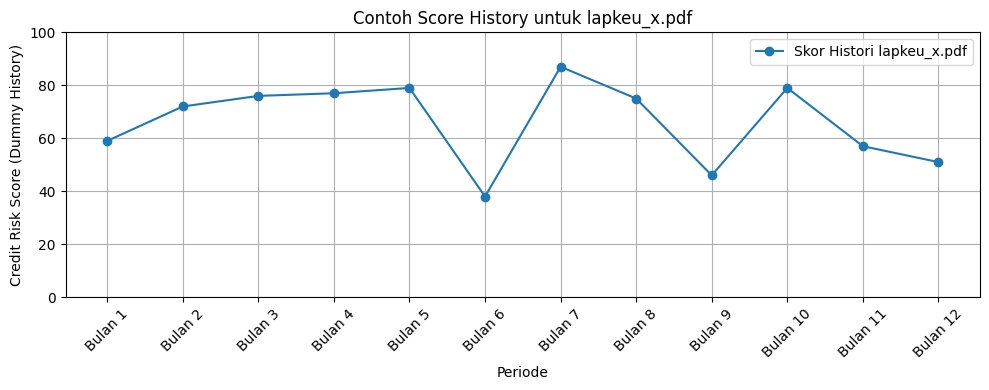

In [29]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Score History (per applicant) - Data Dummy untuk Plot
score_history_data_dummy = {
    COMPANY_NAME_DISPLAY: np.random.randint(30, 90, size=12),
    "Perusahaan Lain B (Dummy)": np.random.randint(40, 100, size=12),
    "Perusahaan Lain C (Dummy)": np.random.randint(20, 70, size=12)
}
months = [f"Bulan {i+1}" for i in range(12)]

plt.figure(figsize=(10, 4))
if COMPANY_NAME_DISPLAY in score_history_data_dummy:
    plt.plot(months, score_history_data_dummy[COMPANY_NAME_DISPLAY], marker='o', label=f"Skor Histori {COMPANY_NAME_DISPLAY}")
    plt.title(f"Contoh Score History untuk {COMPANY_NAME_DISPLAY}")
else:
    default_key = list(score_history_data_dummy.keys())[0]
    plt.plot(months, score_history_data_dummy[default_key], marker='o', label=f"Skor Histori {default_key}")
    plt.title(f"Contoh Score History untuk {default_key}")
    print(f"Peringatan: COMPANY_NAME_DISPLAY ('{COMPANY_NAME_DISPLAY}') tidak ditemukan di score_history_data_dummy. Menampilkan plot untuk {default_key}.")

plt.xlabel("Periode")
plt.ylabel("Credit Risk Score (Dummy History)")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Approval Recommendation
recommendation = ""
recommendation_icon = ""
if risk_category == "Low Risk":
    recommendation = "Approve"
    recommendation_icon = "✔️"
elif risk_category == "Medium Risk":
    recommendation = "Butuh Review Lanjutan"
    recommendation_icon = "🟡"
else:
    recommendation = "Decline"
    recommendation_icon = "❌"

analisis_box = widgets.VBox(
    [
        widgets.HTML(
            value=f"<b>Analisis untuk Perusahaan:</b> {COMPANY_NAME_DISPLAY}",
            layout=widgets.Layout(margin='0px 0px 10px 0px', font_weight='bold')
        ),
        widgets.Label("Skor Risiko Kredit Aktual:"),
        score_gauge,
        risk_label,
        widgets.HTML(
            value=f"<b>Rekomendasi:</b> {recommendation_icon} {recommendation}",
            layout=widgets.Layout(margin='10px 0px 0px 0px')
        )
    ],
    layout=widgets.Layout(
        border='1px solid #ccc',
        padding='15px',
        margin='10px',
        background_color='#f9f9f9',
        width='auto',
        box_shadow='2px 2px 5px rgba(0,0,0,0.1)'
    )
)

display(analisis_box)

## 7. Kesimpulan Analisis

Berdasarkan hasil perhitungan di atas:
*   **Beneish M-Score**: Memberikan indikasi apakah ada potensi manipulasi laba.
*   **Altman Z-Score**: Memberikan prediksi mengenai risiko kebangkrutan.
*   **Rasio Keuangan Umum**: Memberikan gambaran kesehatan keuangan secara umum dan dapat digunakan sebagai dasar penilaian risiko kredit.

Analisis ini sebaiknya digunakan sebagai salah satu alat bantu dalam pengambilan keputusan dan dikombinasikan dengan analisis kualitatif serta informasi pasar lainnya.